In [1]:
import os
import json
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
hospital_file = '..//YAIB-cohorts/data/mortality24/eicu/above2000.txt'
df = pd.read_csv(hospital_file, header=None)

In [3]:
n = 12
hospital_ids = df[0].values[:n]

In [6]:
model = 'LSTM'
avg_dict = np.load(f'results/dist_shift/{model}-avg.npz') 
ci_dict = np.load(f'results/dist_shift/{model}-ci.npz') 

Text(0.5, 0.98, 'LSTM Train-Test AUC drop across hospitals')

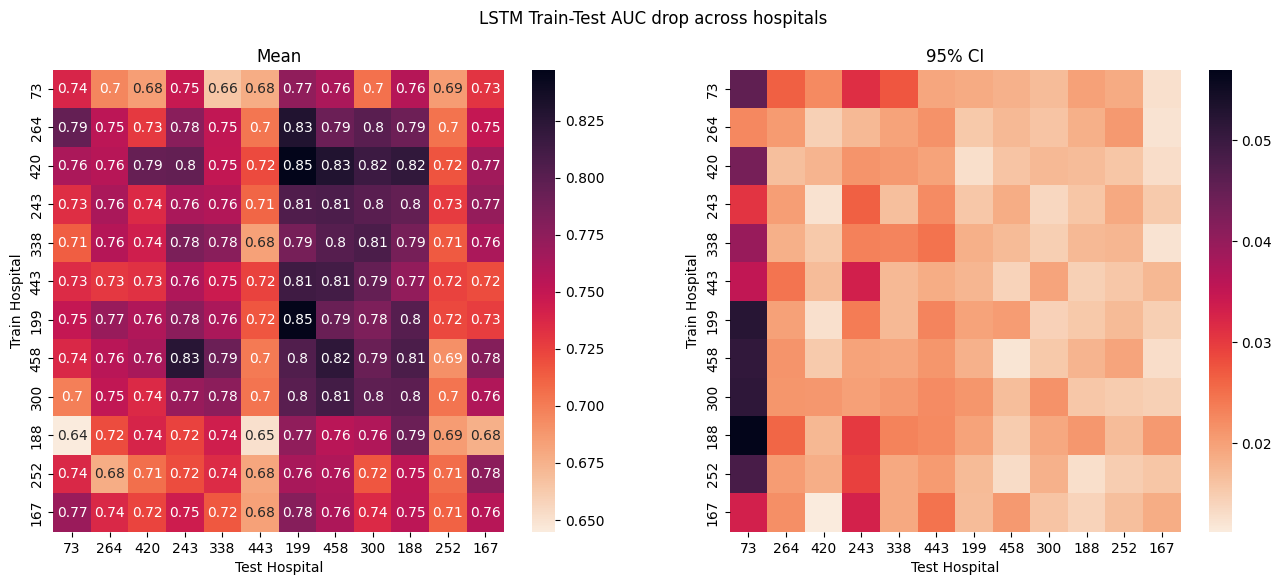

In [7]:
metric = 'AUC'
fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)

sns.heatmap(avg_dict[metric], annot=True, cmap="rocket_r", ax=axes[0], 
                      xticklabels=hospital_ids, 
           yticklabels=hospital_ids,)
axes[0].set_xlabel("Test Hospital")
axes[0].set_ylabel("Train Hospital")
axes[0].set_title("Mean")


CI = ci_dict[metric][1] - avg_dict[metric]
sns.heatmap(CI, fmt=".2e", annot_kws={'fontsize':7}, cmap="rocket_r", 
                      xticklabels=hospital_ids, 
           yticklabels=hospital_ids,)
axes[1].set_xlabel("Test Hospital")
axes[1].set_ylabel("Train Hospital")
axes[1].set_title("95% CI")

plt.suptitle(f"{model} Train-Test {metric} drop across hospitals")

Text(0.5, 1.0, 'LSTM AUC Change Between Train and Test Hospitals')

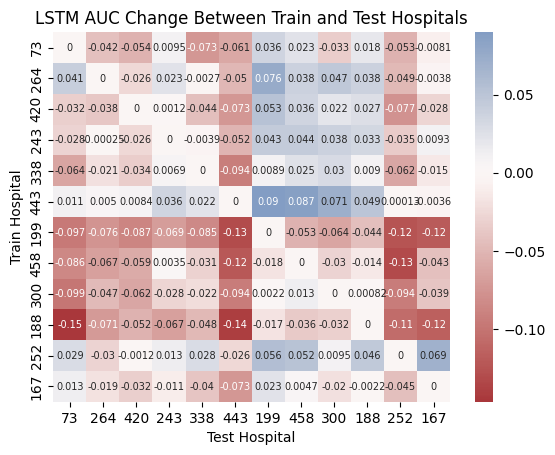

In [8]:
# Differences
diff = avg_dict[metric] - np.repeat(np.diagonal(avg_dict[metric]).reshape(-1, 1), len(hospital_ids), axis=1)
sns.heatmap(diff, annot=True, 
            annot_kws={'fontsize':7}, cmap="vlag_r", 
           xticklabels=hospital_ids, 
           yticklabels=hospital_ids,
           center=0)
plt.xlabel("Test Hospital")
plt.ylabel("Train Hospital")
plt.title(f"{model} {metric} Change Between Train and Test Hospitals")

In [10]:
metric = 'AUC'
keys_gender = [(f'{metric}', 'All'), 
               (f'gender0_{metric}_TEST', 'Female'),  
                (f'gender1_{metric}_TEST', 'Male')]
keys_race = [(f'{metric}', 'All'),
        (f'race0_{metric}_TEST', 'Asian'), 
        (f'race1_{metric}_TEST', 'Black'), 
        (f'race2_{metric}_TEST', 'Other'),
        (f'race3_{metric}_TEST', 'White')]

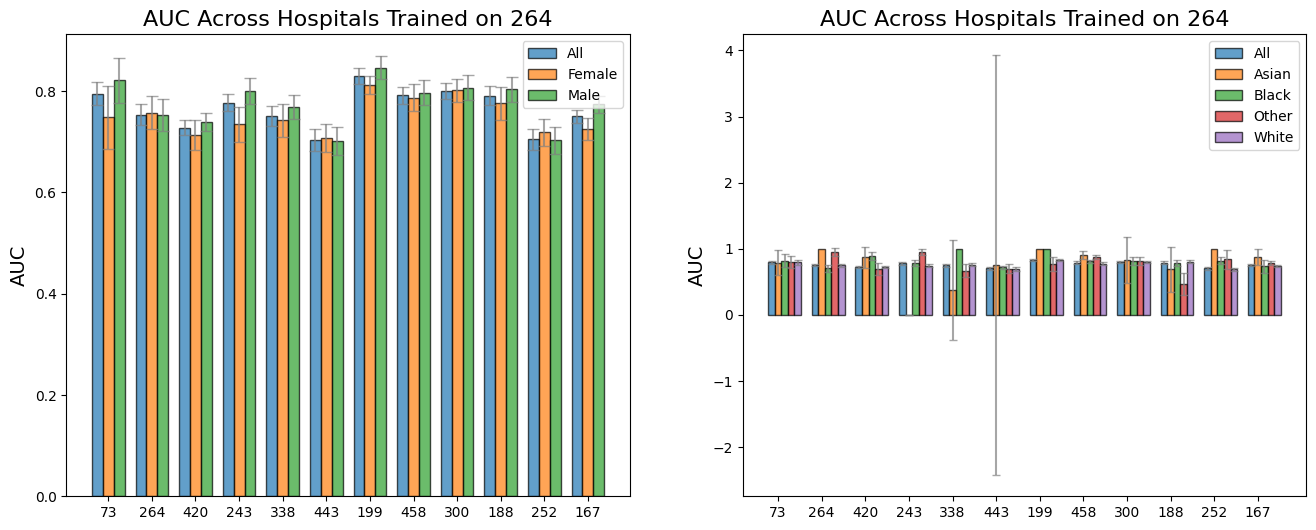

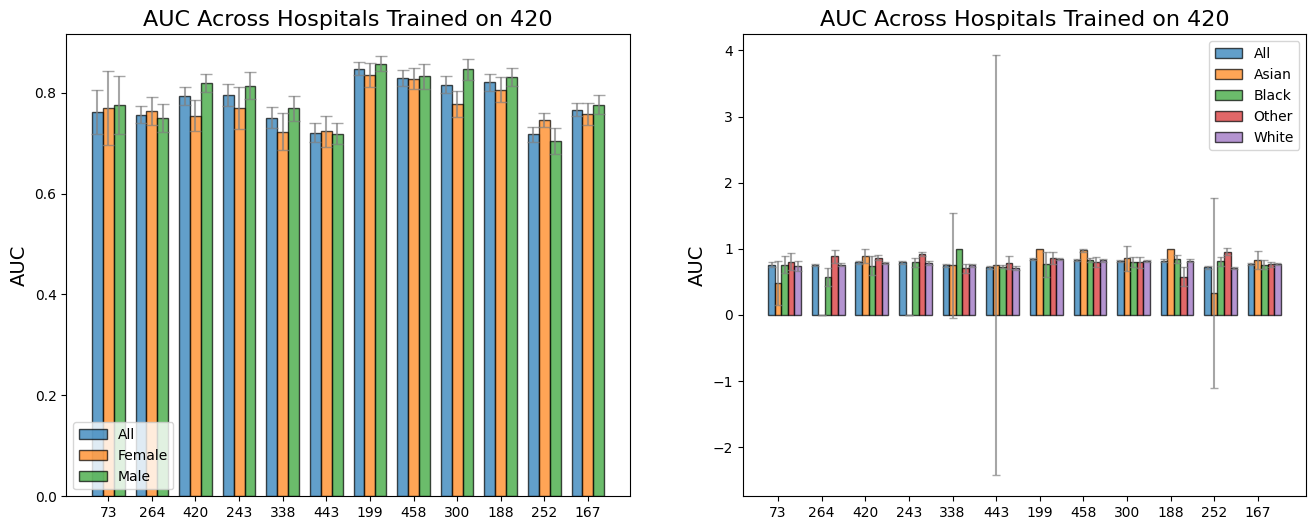

In [11]:
# for train hospital 73
for train_hid in [1, 2]:  
    # Plot the bars
    fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
    # Set the bar positions and width
    bar_positions = np.arange(len(hospital_ids))
    bar_width = 0.25
    
    ax = axes[0]
    for i, (key, label) in enumerate(keys_gender): 
        auc_values = avg_dict[key][train_hid]
        lower_ci = ci_dict[key][0][train_hid]
        upper_ci = ci_dict[key][1][train_hid]
        
        bars = ax.bar(bar_positions+i*bar_width, 
                      auc_values, bar_width, alpha=0.7, 
                      edgecolor='black', label=label)
        
        # Plot the error bars
        error_bars = ax.errorbar(bar_positions+i*bar_width,
                                 auc_values, 
                                 yerr=[np.array(auc_values) - np.array(lower_ci), 
                                       np.array(upper_ci) - np.array(auc_values)], 
                                 capsize=4, fmt='none', ecolor='gray', alpha=0.7)
        
        # Add labels and titles
        ax.set_xticks(bar_positions+bar_width)
        ax.set_xticklabels(hospital_ids)
        ax.set_ylabel(f'{metric}', fontsize=14)
        ax.set_title(f'{metric} Across Hospitals Trained on {hospital_ids[train_hid]}', fontsize=16)
        ax.legend()
    
    bar_width = 0.15
    ax = axes[1]
    for i, (key, label) in enumerate(keys_race): 
        auc_values = avg_dict[key][train_hid]
        lower_ci = ci_dict[key][0][train_hid]
        upper_ci = ci_dict[key][1][train_hid]
        
        bars = ax.bar(bar_positions+i*bar_width, 
                      auc_values, bar_width, alpha=0.7, 
                      edgecolor='black', label=label)
        
        # Plot the error bars
        error_bars = ax.errorbar(bar_positions+i*bar_width,
                                 auc_values, 
                                 yerr=[np.array(auc_values) - np.array(lower_ci), 
                                       np.array(upper_ci) - np.array(auc_values)], 
                                 capsize=3, fmt='none', ecolor='gray', alpha=0.7)
        
        # Add labels and titles
        ax.set_xticks(bar_positions+bar_width)
        ax.set_xticklabels(hospital_ids)
        ax.set_ylabel(f'{metric}', fontsize=14)
        ax.set_title(f'{metric} Across Hospitals Trained on {hospital_ids[train_hid]}', fontsize=16)
        ax.legend()
        
        # # Adjust the y-axis limits
        
        # # Add value labels on top of the bars
        # for bar, auc in zip(bars, auc_values):
        #     height = bar.get_height() +0.04
        #     print(height)
        #     ax.annotate(f'{auc:.2f}',
        #                 xy=(bar.get_x() + bar.get_width() / 2, height),
        #                 xytext=(0, 3),
        #                 textcoords="offset points",
        #                 ha='center', va='bottom', fontsize=10)

## Correlation

In [11]:
LR = np.load('results/dist_shift/LogisticRegression-avg.npz')
LGBM = np.load('results/dist_shift/LGBMClassifier-avg.npz')
LSTM = np.load('results/dist_shift/LSTM-avg.npz')

In [12]:
metric = 'AUC'
plot_df = pd.DataFrame()
plot_df['LR'] = LR[metric].flatten()
plot_df['LGBM'] = LGBM[metric].flatten()
plot_df['LSTM'] = LSTM[metric].flatten()
plot_df['train_hospital'] = np.repeat(hospital_ids, repeats=len(hospital_ids))
plot_df['train_hospital'] = plot_df['train_hospital'].astype(str)
plot_df['test_hospital'] = np.repeat(hospital_ids.reshape(-1, 1), repeats=len(hospital_ids), axis=1).T.flatten()

Text(0.5, 1.0, 'LSTM vs. LR  Correlation')

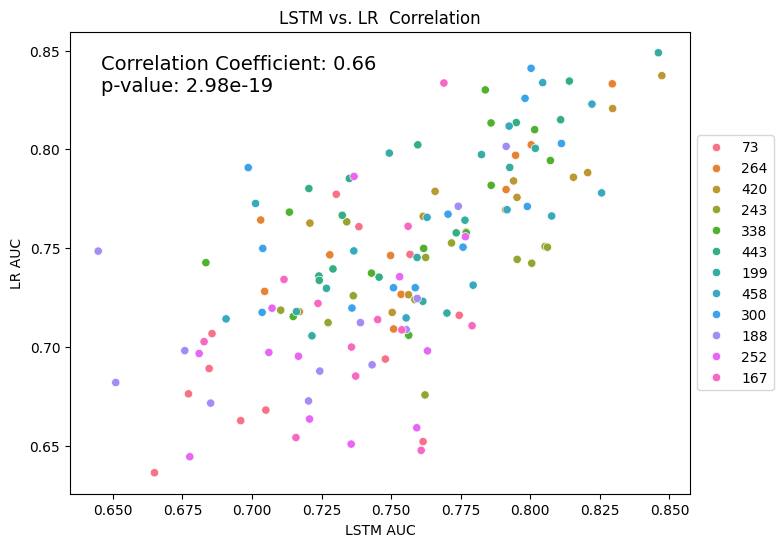

In [18]:
from scipy.stats import pearsonr

clf1 = 'LSTM'
clf2 = 'LR'
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=plot_df, x=clf1, y=clf2, hue='train_hospital')
corr_coef, p_value = pearsonr(plot_df[clf1], plot_df[clf2])

# Add correlation coefficient and p-value to the plot
text_str = f'Correlation Coefficient: {corr_coef:.2f}\np-value: {p_value:.2e}'
ax.text(0.05, 0.95, text_str, transform=ax.transAxes,
        fontsize=14, verticalalignment='top')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel(f'{clf1} {metric}')
ax.set_ylabel(f'{clf2} {metric}')
ax.set_title(f'{clf1} vs. {clf2}  Correlation')

# Loading Data Section: 
Need checkpoints to run -- stick to above code for loading data

In [60]:
model = 'LSTM'
log_dir = f'/home/ubuntu/projects/more-data-more-problems/yaib_logs/eicu/Mortality24/{model}'
avg_dict = {} 
std_dict = {} 
ci_dict = {} 
for i, train_hos in enumerate(hospital_ids): 
    for j, test_hos in enumerate(hospital_ids): 
        
        dir_str = f"train{train_hos}-test{test_hos}"
        exp_dir = os.path.join(log_dir, dir_str)
        if model == 'LSTM' and i != j: 
            exp_dir = os.path.join(exp_dir, '_from_eicu')
        files = os.listdir(exp_dir)
        # folders only 
        files = [name for name in files if os.path.isdir(os.path.join(exp_dir, name)) and not name.startswith('.')]
        paths = [os.path.join(exp_dir, basename) for basename in files]
        target_dir = max(paths, key=os.path.getctime)

        f = open(os.path.join(target_dir, 'accumulated_test_metrics.json'))
        result_dict = json.load(f)
        for keyword, key_dict in zip(['avg', 'std'], [avg_dict, std_dict]): 
            key_results = result_dict[keyword]
            for key in key_results.keys(): 
                if key not in key_dict.keys(): 
                    key_dict[key] = np.zeros((n, n))
    
                key_dict[key][i, j] = key_results[key]
        ci = result_dict['CI_0.95']
        for key in ci.keys(): 
            if key not in ci_dict.keys(): 
                ci_dict[key] = (np.zeros((n, n)), np.zeros((n, n)))
            ci_dict[key][0][i, j] = ci[key][0]
            ci_dict[key][1][i, j] = ci[key][1]

# saving results
np.savez(f"results/dist_shift/{model}-avg.npz", **avg_dict)
np.savez(f"results/dist_shift/{model}-std.npz", **std_dict)
np.savez(f"results/dist_shift/{model}-ci.npz", **ci_dict)

## Data Addition

In [12]:
model = 'LogisticRegression'
log_dir = f'/home/ubuntu/projects/more-data-more-problems/yaib_logs/eicu/Mortality24/{model}'
avg_dict = {} 
std_dict = {} 
ci_dict = {} 
for i, train_hos in enumerate(hospital_ids): 
    for j, test_hos in enumerate(hospital_ids): 
        if i != j: 
            dir_str = f"train{train_hos}-{test_hos}-test{test_hos}"
            exp_dir = os.path.join(log_dir, dir_str)
            files = os.listdir(exp_dir)
            files.sort()
            datetime = files[-1]
            f = open(os.path.join(exp_dir, datetime, 'accumulated_test_metrics.json'))
            result_dict = json.load(f)
            for keyword, key_dict in zip(['avg', 'std'], [avg_dict, std_dict]): 
                key_results = result_dict[keyword]
                for key in key_results.keys(): 
                    if key not in key_dict.keys(): 
                        key_dict[key] = np.zeros((n, n))
        
                    key_dict[key][i, j] = key_results[key]
            ci = result_dict['CI_0.95']
            for key in ci.keys(): 
                if key not in ci_dict.keys(): 
                    ci_dict[key] = (np.zeros((n, n)), np.zeros((n, n)))
                ci_dict[key][0][i, j] = ci[key][0]
                ci_dict[key][1][i, j] = ci[key][1]


np.savez(f"results/add_data/{model}-avg.npz", **avg_dict)
np.savez(f"results/add_data/{model}-std.npz", **std_dict)
np.savez(f"results/add_data/{model}-ci.npz", **ci_dict)

In [65]:
dist_shift_avg = np.load(f"results/dist_shift/{model}-avg.npz")

Text(0.5, 0.98, 'LSTM Train-Test AUC drop across hospitals')

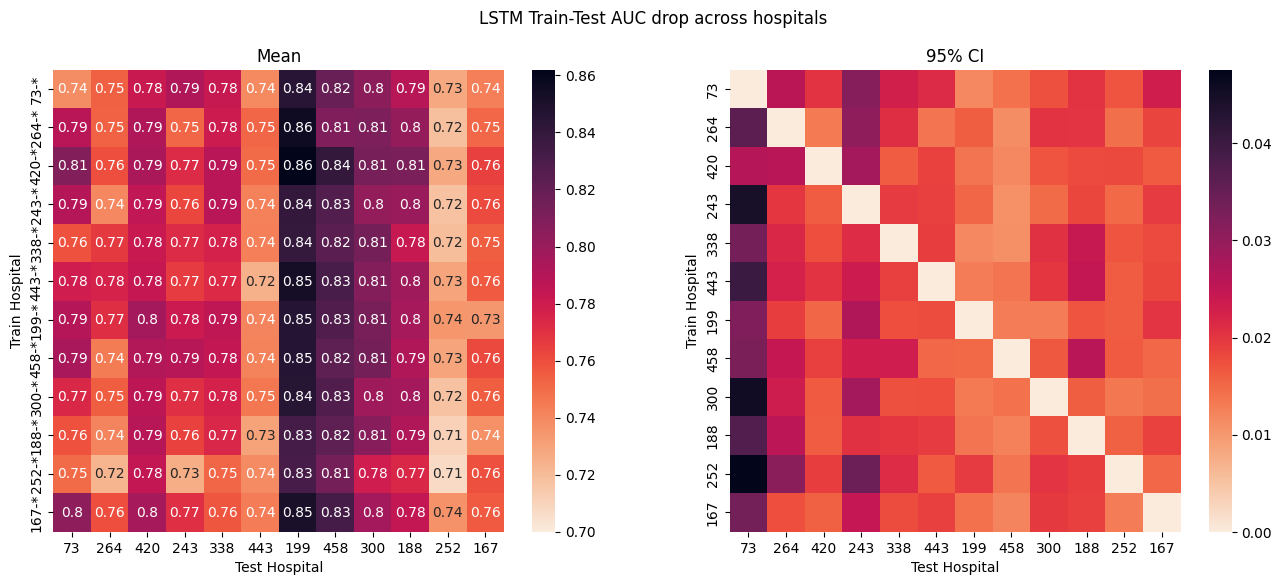

In [66]:
metric = 'AUC'
fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
train_test_ids = [f"{h}-*" for h in hospital_ids]
plot_mat = avg_dict[metric] + np.diagonal(dist_shift_avg[metric])*np.eye(len(hospital_ids)) 
           
sns.heatmap(plot_mat, annot=True, cmap="rocket_r", ax=axes[0], 
            xticklabels=hospital_ids, 
           yticklabels=train_test_ids, 
           vmin=0.7)
axes[0].set_xlabel("Test Hospital")
axes[0].set_ylabel("Train Hospital")
axes[0].set_title("Mean")


CI = ci_dict[metric][1] - avg_dict[metric]
sns.heatmap(CI, fmt=".2e", annot_kws={'fontsize':7}, cmap="rocket_r", 
                      xticklabels=hospital_ids, 
           yticklabels=hospital_ids,)
axes[1].set_xlabel("Test Hospital")
axes[1].set_ylabel("Train Hospital")
axes[1].set_title("95% CI")

plt.suptitle(f"{model} Train-Test {metric} drop across hospitals")

In [67]:
addition_diff = plot_mat - np.repeat(np.diagonal(dist_shift_avg[metric]).reshape(-1, 1), len(hospital_ids), axis=1)

Text(0.5, 1.0, 'LSTM AUC Change Between Train and Test Hospitals')

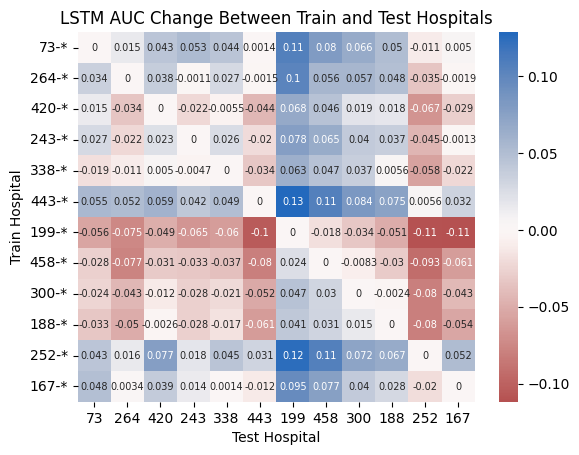

In [68]:
sns.heatmap(addition_diff, annot=True, 
            annot_kws={'fontsize':7}, cmap="vlag_r", 
           xticklabels=hospital_ids, 
           yticklabels=train_test_ids,
           center=0)
plt.xlabel("Test Hospital")
plt.ylabel("Train Hospital")
plt.title(f"{model} {metric} Change Between Train and Test Hospitals")

In [22]:
shift_diff = dist_shift_avg[metric] - np.repeat(np.diagonal(dist_shift_avg[metric]).reshape(-1, 1), len(hospital_ids), axis=1)

In [23]:
plot_df = pd.DataFrame()
plot_df['OOD'] = shift_diff.flatten()
plot_df['Data-Addition'] = addition_diff.flatten()
plot_df['train_hospital'] = np.repeat(train_test_ids, repeats=len(hospital_ids))
plot_df['test_hospital'] = np.repeat(hospital_ids.reshape(-1, 1), repeats=len(hospital_ids), axis=1).T.flatten()

In [24]:
plot_df.drop(index=np.linspace(0, 144, 13)[:-1])

,OOD,Data-Addition,train_hospital,test_hospital
1,-0.139032,-0.005985,73-*,264
2,-0.099156,0.047083,73-*,420
3,-0.080803,0.026285,73-*,243
4,-0.110083,0.011689,73-*,338
5,-0.105600,-0.002949,73-*,443
...,...,...,...,...
139,0.001578,0.075802,167-*,458
140,0.008958,0.062390,167-*,300
141,0.003912,0.048460,167-*,188
142,-0.024741,0.011402,167-*,252


Text(0.5, 1.0, 'OOD vs. Data-Addition Correlation')

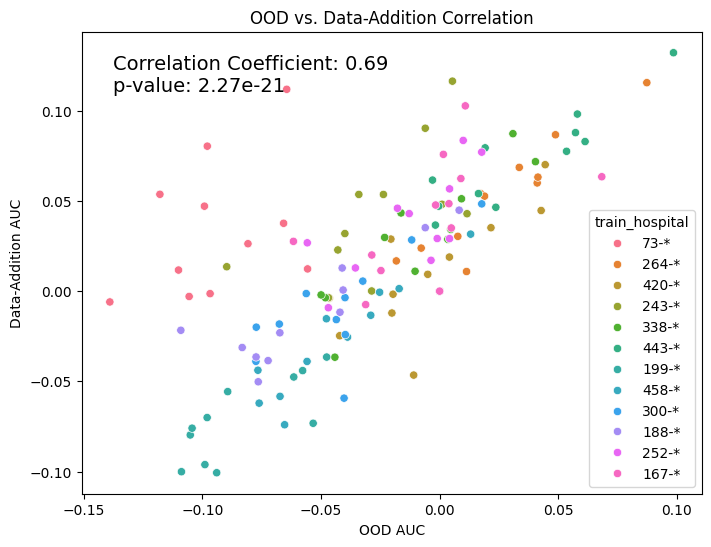

In [25]:
from scipy.stats import pearsonr

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=plot_df, x='OOD', y='Data-Addition', hue='train_hospital')
corr_coef, p_value = pearsonr(plot_df['OOD'], plot_df['Data-Addition'])

# Add correlation coefficient and p-value to the plot
text_str = f'Correlation Coefficient: {corr_coef:.2f}\np-value: {p_value:.2e}'
ax.text(0.05, 0.95, text_str, transform=ax.transAxes,
        fontsize=14, verticalalignment='top')

ax.set_xlabel(f'OOD {metric}')
ax.set_ylabel(f'Data-Addition {metric}')
ax.set_title(f'OOD vs. Data-Addition Correlation')

In [24]:
model = 'LogisticRegression'
log_dir = f'/home/ubuntu/projects/more-data-more-problems/yaib_logs/eicu/Mortality24/{model}'
avg_dict = {} 
std_dict = {} 
ci_dict = {} 
hos=443
for n in [1000, 1500, 2000, 2500]: 
    dir_str = f"train-test{hos}-n{n}"
    exp_dir = os.path.join(log_dir, dir_str)
    files = os.listdir(exp_dir)
    # folders only 
    files = [name for name in files if os.path.isdir(os.path.join(exp_dir, name)) and not name.startswith('.')]
    paths = [os.path.join(exp_dir, basename) for basename in files]
    target_dir = max(paths, key=os.path.getctime)

    f = open(os.path.join(target_dir, 'accumulated_test_metrics.json'))
    result_dict = json.load(f)
    for keyword, key_dict in zip(['avg', 'std'], [avg_dict, std_dict]): 
        key_results = result_dict[keyword]
        for key in key_results.keys(): 
            if key not in key_dict.keys(): 
                key_dict[key] = {}
            key_dict[key][n] = key_results[key]
    ci = result_dict['CI_0.95']
    for key in ci.keys(): 
        if key not in ci_dict.keys(): 
            ci_dict[key] = ({}, {})
        ci_dict[key][0][n] = ci[key][0]
        ci_dict[key][1][n] = ci[key][1]

np.savez(f"results/sequential-n/{model}-avg.npz", **avg_dict)
np.savez(f"results/sequential-n/{model}-CI.npz", **ci_dict)